# Imports

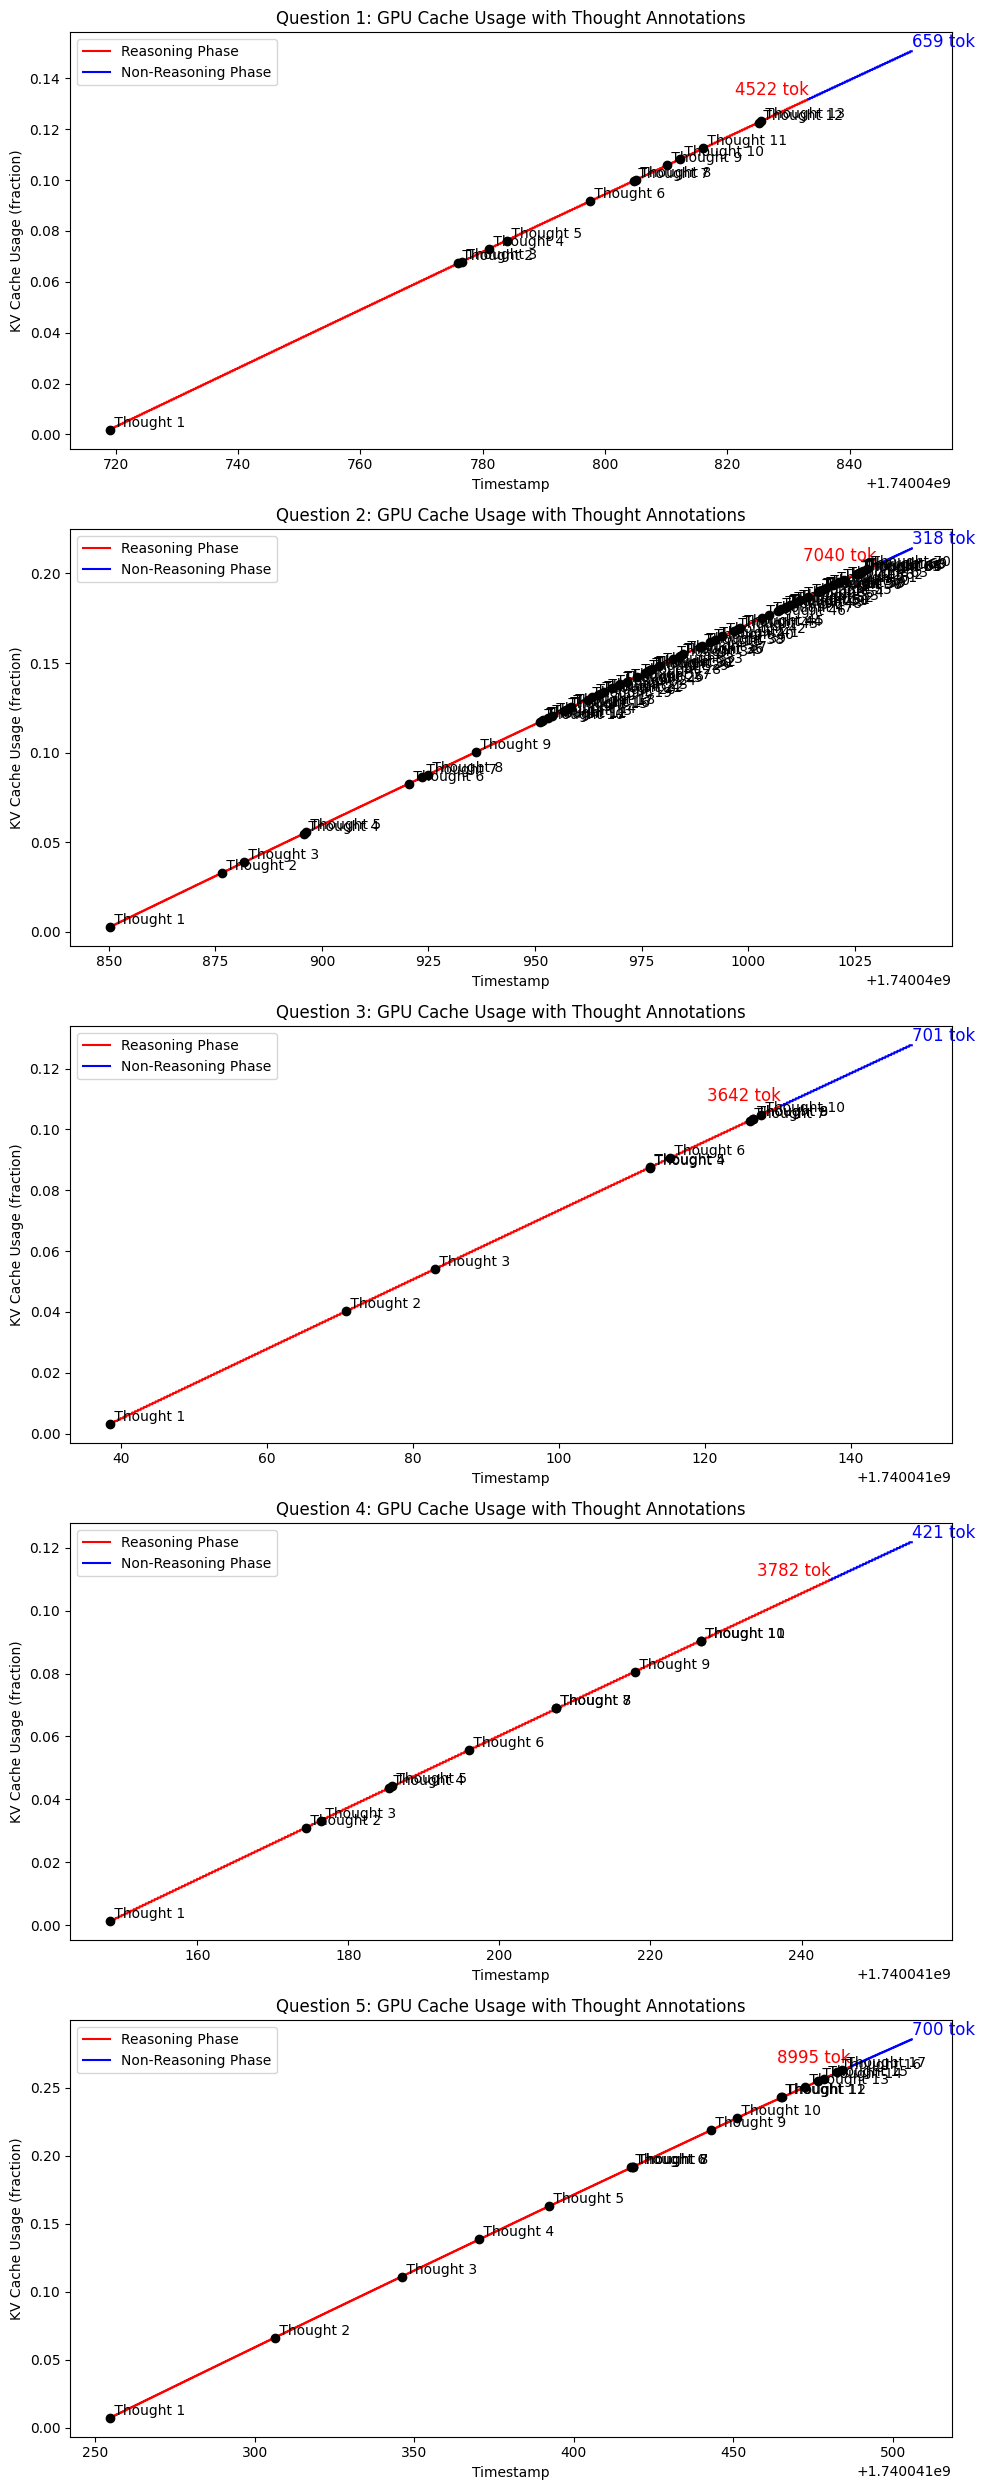

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast

# Read token counts which contains the reasoning tokens counts for each question.
token_counts_path = '/home/colin/vllm/scratch/token_counts.csv'
df_counts = pd.read_csv(token_counts_path)

# Determine the number of questions based on the number of rows in token_counts.csv
num_questions = len(df_counts)

# Prepare filenames for each question CSV (the file has a header row with timestamp,gpu_cache_usage_sys)
question_files = [f'/home/colin/vllm/scratch/kvcache_usages/question_{i}.csv' for i in range(1, num_questions + 1)]

# Create a subplot for each question
fig, axes = plt.subplots(num_questions, 1, figsize=(10, 5 * num_questions), squeeze=False)

for idx, file in enumerate(question_files):
    ax = axes[idx][0]
    # Load the CSV for question i and ignore the first entry
    df_question = pd.read_csv(file).iloc[1:]
    timestamps = df_question['timestamp'].values
    usage = df_question['gpu_cache_usage_sys'].values

    # Get reasoning token count for this question from token_counts.csv
    reasoning_count = int(df_counts.loc[idx, 'Reasoning Tokens'])
    non_reasoning_count = len(timestamps) - reasoning_count

    # Plot reasoning phase (first reasoning_count rows) in red.
    if reasoning_count > 0:
        ax.plot(timestamps[:reasoning_count], usage[:reasoning_count],
                color='red', label='Reasoning Phase')
        ax.text(timestamps[reasoning_count-1], usage[reasoning_count-1],
                f'{reasoning_count} tok', color='red', fontsize=12,
                verticalalignment='bottom', horizontalalignment='right')

    # Plot non-reasoning phase (remaining rows) in blue.
    if reasoning_count < len(timestamps):
        ax.plot(timestamps[reasoning_count:], usage[reasoning_count:],
                color='blue', label='Non-Reasoning Phase')
        ax.text(timestamps[-1], usage[-1],
                f'{non_reasoning_count} tok', color='blue', fontsize=12,
                verticalalignment='bottom', horizontalalignment='left')

    # Mark and annotate each thought position from token_counts.csv
    thought_positions_str = df_counts.loc[idx, 'Thought Positions']
    thought_positions = ast.literal_eval(thought_positions_str)  # Convert string to a list
    for j, pos in enumerate(thought_positions):
        # Ensure pos is within bounds (skip if not)
        if pos < len(timestamps):
            ts = timestamps[pos]
            usage_val = usage[pos]
            ax.plot(ts, usage_val, 'ko', markersize=6)  # Mark with a black dot
            ax.text(ts, usage_val, f' Thought {j+1}', color='black', fontsize=10,
                    verticalalignment='bottom', horizontalalignment='left')

    ax.set_xlabel('Timestamp')
    ax.set_ylabel('KV Cache Usage (fraction)')
    ax.set_title(f'Question {idx+1}: GPU Cache Usage with Thought Annotations')
    ax.legend()

plt.tight_layout()
plt.show()

# Box plot of total KV cache usage (reasoning part) vs. Thought Count

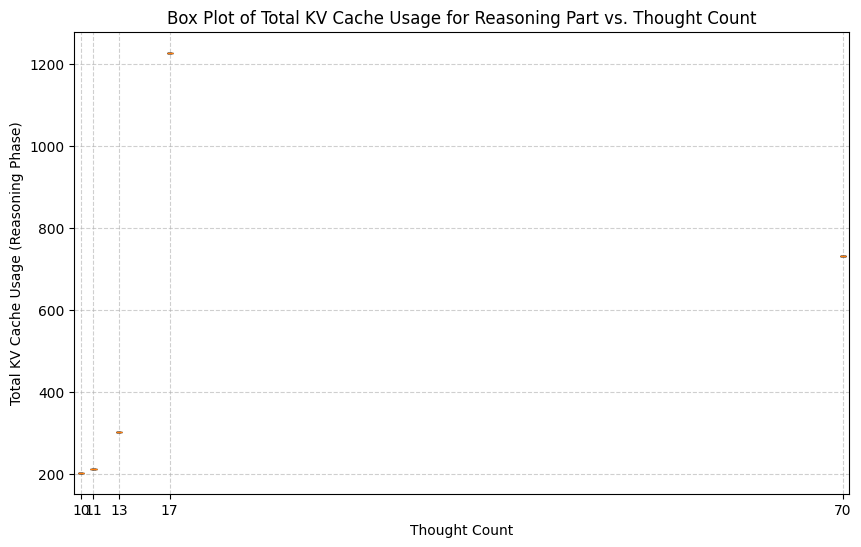

In [10]:
# Dictionary to accumulate total reasoning usage grouped by Thought Count.
thought_usage = {}

# Iterate over each question file and compute the total reasoning usage.
for idx, file in enumerate(question_files):
    # Load the CSV for question i while ignoring the first entry.
    df_question = pd.read_csv(file).iloc[1:]
    timestamps = df_question['timestamp'].values
    usage = df_question['gpu_cache_usage_sys'].values
    
    # Get reasoning token count for this question from token_counts.csv
    reasoning_count = int(df_counts.loc[idx, 'Reasoning Tokens'])
    # Get Thought Count for this question from token_counts.csv
    thought_count = int(df_counts.loc[idx, 'Thought Count'])
    
    # Compute total reasoning usage if reasoning phase exists.
    if reasoning_count > 0 and reasoning_count <= len(usage):
        total_usage_reasoning = sum(usage[:reasoning_count])
        if thought_count not in thought_usage:
            thought_usage[thought_count] = []
        thought_usage[thought_count].append(total_usage_reasoning)

# Prepare data for box plot.
sorted_thought_counts = sorted(thought_usage.keys())
data = [thought_usage[k] for k in sorted_thought_counts]

# Create the box plot.
fig2, ax2 = plt.subplots(figsize=(10, 6))
box_props = dict(facecolor='lightblue')
bp = ax2.boxplot(data, positions=sorted_thought_counts, patch_artist=True, boxprops=box_props)

ax2.set_xlabel('Thought Count')
ax2.set_ylabel('Total KV Cache Usage (Reasoning Phase)')
ax2.set_title('Box Plot of Total KV Cache Usage for Reasoning Part vs. Thought Count')
ax2.set_xticks(sorted_thought_counts)
ax2.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Calculations

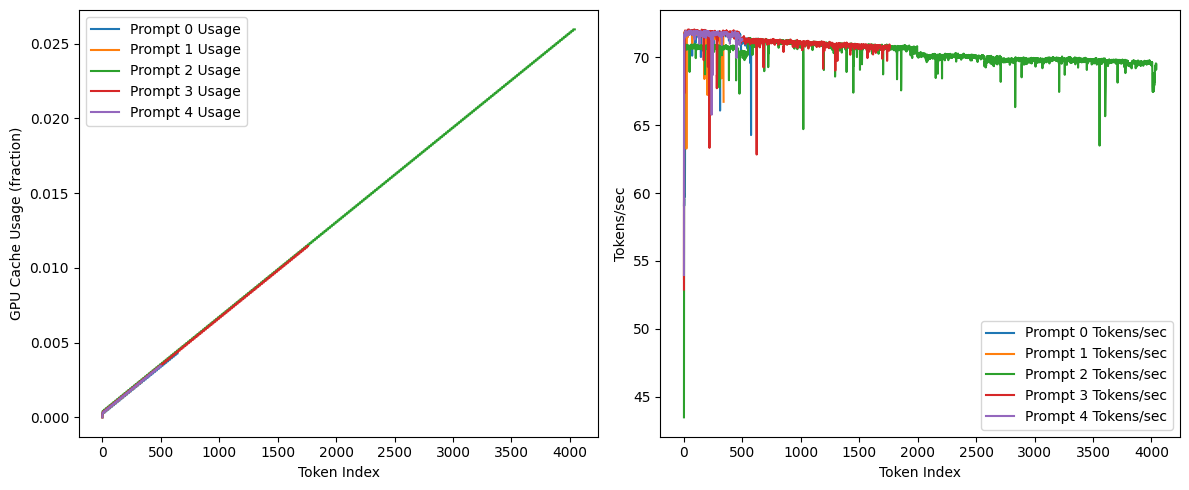

In [ ]:
# # List of CSV filenames
# filenames = [f'kvcache_usage_{i}.csv' for i in range(1, 6)]

# plt.figure(figsize=(12, 5))
# ax1 = plt.subplot(1, 2, 1)  # Usage plot
# ax2 = plt.subplot(1, 2, 2)  # Tokens/sec plot

# for i in range(len(filenames)):
#     df = pd.read_csv(filenames[i])
#     timestamps = df['timestamp'].values
#     usage = df['gpu_cache_usage_sys'].values

#     # Compute tokens per second by taking differences of timestamps
#     # Avoid division by zero by ensuring no time diff is 0.
#     time_diffs = np.diff(timestamps)
#     tokens_per_sec = 1.0 / time_diffs

#     ax1.plot(usage, label=f'Prompt {i} Usage')
#     ax2.plot(tokens_per_sec, label=f'Prompt {i} Tokens/sec')

# ax1.set_xlabel('Token Index')
# ax1.set_ylabel('GPU Cache Usage (fraction)')
# ax1.legend()
# ax2.set_xlabel('Token Index')
# ax2.set_ylabel('Tokens/sec')
# ax2.legend()

# plt.tight_layout()
# plt.show()